# Integrating PBMCs

## Imports

In [ ]:
# Biology
import scanpy as sc
import muon as mu
import mowgli

In [2]:
# Plotting
import matplotlib.pyplot as plt

## Load data

Load the preprocessed PBMC dataset from 10X Genomics (scRNA-seq + scATAC-seq). You can download the dataset from https://figshare.com/s/4c8e72cbb188d8e1cce8

In [ ]:
mdata = mu.read_h5mu('pbmc_preprocessed.h5mu.gz')

For computational reasons, in this demonstration we reduce the number of features and subsample the cells.

In [4]:
sc.pp.highly_variable_genes(mdata['rna'], n_top_genes=800)
sc.pp.highly_variable_genes(mdata['atac'], n_top_genes=800)

In [ ]:
# Perform the subsampling.
sc.pp.subsample(mdata['rna'], n_obs=500, random_state=0)
sc.pp.subsample(mdata['atac'], n_obs=500, random_state=0)

# Create a MuData object with rna and atac.
mdata = mu.MuData({'rna': mdata['rna'], 'atac': mdata['atac']})

## Visualize independant modalities

Let us visualize the cell lines independantly using UMAP projections.

In [6]:
# Reorder categories.
ordered_cat = ['CD56 (bright) NK cells', 'CD56 (dim) NK cells', 'MAIT T cells', 'effector CD8 T cells', 'naive CD8 T cells', 'naive CD4 T cells', 'memory CD4 T cells', 'naive B cells', 'memory B cells', 'classical monocytes', 'intermediate monocytes', 'non-classical monocytes', 'myeloid DC', 'plasmacytoid DC']
mdata['rna'].obs['celltype'] = mdata['rna'].obs['celltype'].cat.reorder_categories(ordered_cat)
mdata['atac'].obs['celltype'] = mdata['atac'].obs['celltype'].cat.reorder_categories(ordered_cat)
mdata.obs['rna:celltype'] = mdata.obs['rna:celltype'].cat.reorder_categories(ordered_cat)
mdata.obs['atac:celltype'] = mdata.obs['atac:celltype'].cat.reorder_categories(ordered_cat)

In [7]:
# Umap RNA
sc.pp.scale(mdata['rna'], zero_center=False)
sc.tl.pca(mdata['rna'], svd_solver='arpack')
sc.pp.neighbors(mdata['rna'], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata['rna'], spread=1.5, min_dist=.5)

In [8]:
# Umap ATAC
sc.pp.scale(mdata['atac'], zero_center=False)
sc.tl.pca(mdata['atac'], svd_solver='arpack')
sc.pp.neighbors(mdata['atac'], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata['atac'], spread=1.5, min_dist=.5)

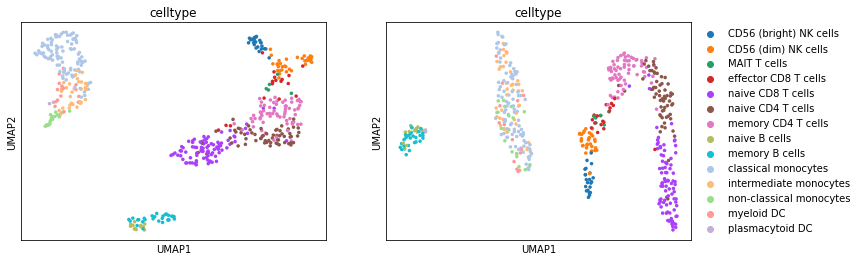

In [9]:
# Display UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sc.pl.umap(mdata['rna'], color="celltype", legend_loc="none", size=50, show=False, ax=axes[0])
sc.pl.umap(mdata['atac'], color="celltype", size=50, show=False, ax=axes[1])
plt.show()

## Train model

Let us define the model and perform the dimensionaly reduction.

In [11]:
# Define the model.
model = mowgli.models.MowgliModel(
    latent_dim=20,
    h_regularization=1e-2,
    w_regularization=1e-3,
    eps=0.1,
    cost="cosine",
)


In [12]:
# Perform the training.
model.train(mdata)

  4%|▍         | 8/200 [01:32<36:55, 11.54s/it, loss=0.044932004, mass_transported=0.805, loss_inner=-0.04926332, inner_steps=190, gpu_memory_allocated=0] 


## Visualize the embedding

Now, let us display the obtained embedding.

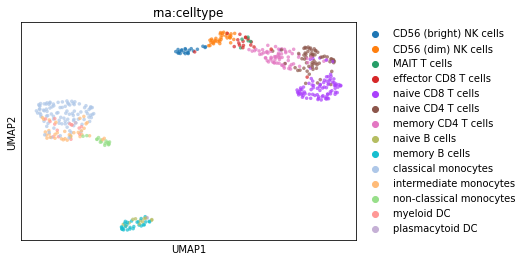

In [36]:
# First using a UMAP plot. This is pure Scanpy!
sc.pp.neighbors(mdata, use_rep="W_OT", key_added="mowgli")
sc.tl.umap(mdata, neighbors_key="mowgli")
sc.pl.umap(mdata, color="rna:celltype", size=50, alpha=.7)

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


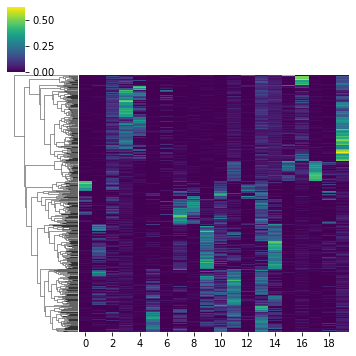

In [14]:
# Then using a dendogram.
mowgli.pl.clustermap(
    mdata,
    obsm="W_OT",
    yticklabels=False,
    figsize=(5, 5),
    col_cluster=False,
)


/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


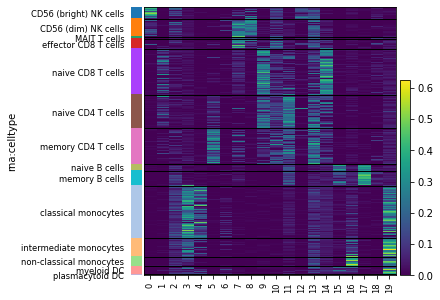

In [15]:
# Then, using a heatmap.
mowgli.pl.heatmap(
    mdata,
    obsm="W_OT",
    groupby="rna:celltype",
    figsize=(5, 5),
)


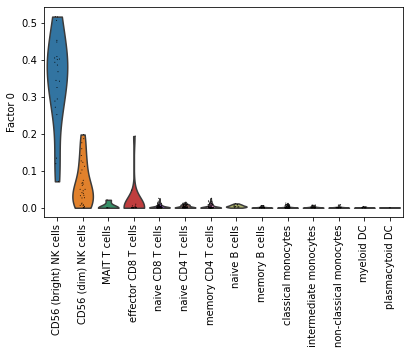

In [23]:
# Finally, display a violin plot of the value at a given dimension of the cells.
mowgli.pl.factor_violin(mdata, groupby='rna:celltype', dim=0, rotation=90)

## Analyse a given factor

We can zoom in on a particular factor to interpret it biologically.

In [26]:
# Display the highest contributors to a given dimension, for RNA-seq.
mowgli.tl.top_features(mdata, mod='rna', uns='H_OT', dim=0, threshold=.8)

['KLRF1', 'GZMB', 'PRF1', 'FGFBP2', 'BNC2', 'SPON2', 'GNLY', 'ADGRG1', 'CST7']

In [32]:
# Query g:profiler for Gene Set Enrichment Analysis, and display the results for a certain dimension.
enr, _ = mowgli.tl.enrich(
    mdata,
    mod="rna",
    n_genes=20,
    domain_scope="annotated",
)
enr[enr["query"] == "dimension 0"].head()[["source", "name", "p_value"]]


,source,name,p_value
3,GO:CC,cytolytic granule,6.467388e-09
5,GO:BP,natural killer cell mediated immunity,8.564591e-08
7,GO:BP,leukocyte mediated immunity,1.615047e-07
8,GO:BP,cell killing,3.389430e-07
18,GO:BP,leukocyte mediated cytotoxicity,2.318705e-06


## Clustering

We can perform clustering on the lower-dimensional space.

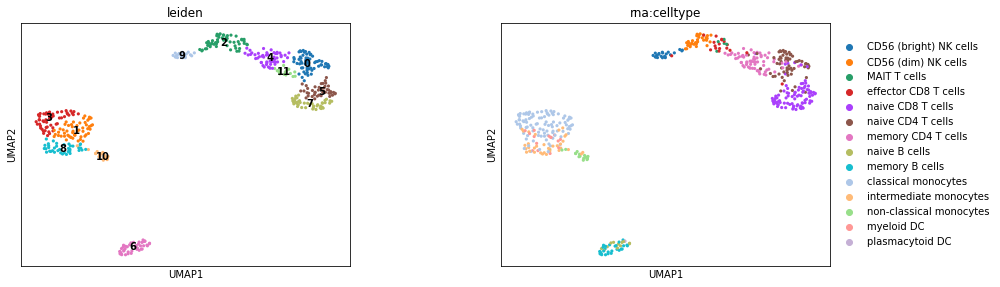

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.tight_layout(pad=12.0)
sc.tl.leiden(mdata, resolution=1.5, neighbors_key="mowgli")
sc.pl.umap(mdata, color='leiden', legend_loc='on data', size=40, ax=axes[0], show=False)
sc.pl.umap(mdata, color='rna:celltype', size=40, ax=axes[1])